In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import optuna

/opt/anaconda3/envs/newUmut/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
if "customerID" in df.columns: 
    df = df.drop(columns="customerID")

    
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())
df["TotalCharges"] = df["TotalCharges"].astype(np.float32)



if df["Churn"].dtype == "object":
    df["Churn"] = df["Churn"].astype(str).str.strip().str.lower().map({"yes": 1, "no": 0})

cat_cols = df.select_dtypes(include=['category', 'object']).columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.str.strip().str.lower())

service_cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
df["TotalServices"] = (df[service_cols] == "yes").sum(axis=1)

df["AverageCostPerService"] = df["MonthlyCharges"] / df["TotalServices"].replace(0, 1)
df["AverageCostPerService"] = df["AverageCostPerService"].astype(np.float32)

df["new_customer"] = np.where(df["tenure"] == 0, 1, 0)

df["Is_auto_payment"] = df["PaymentMethod"].str.contains('automatic').astype(int)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)

In [5]:
df[["tenure", "new_customer"]].corr()

,tenure,new_customer
tenure,1.000000,-0.052135
new_customer,-0.052135,1.000000


In [11]:
df["Contract"].unique()

array(['month-to-month', 'one year', 'two year'], dtype=object)

In [9]:
for col in df.columns:
    print(f"Name: {col}, Type: {df[col].dtype}")

Name: gender, Type: object
Name: SeniorCitizen, Type: int64
Name: Partner, Type: object
Name: Dependents, Type: object
Name: tenure, Type: int64
Name: PhoneService, Type: object
Name: MultipleLines, Type: object
Name: InternetService, Type: object
Name: OnlineSecurity, Type: object
Name: OnlineBackup, Type: object
Name: DeviceProtection, Type: object
Name: TechSupport, Type: object
Name: StreamingTV, Type: object
Name: StreamingMovies, Type: object
Name: Contract, Type: object
Name: PaperlessBilling, Type: object
Name: PaymentMethod, Type: object
Name: MonthlyCharges, Type: float64
Name: TotalCharges, Type: float32
Name: Churn, Type: int64
Name: TotalServices, Type: int64
Name: AverageCostPerService, Type: float32
Name: new_customer, Type: int64
Name: Is_auto_payment, Type: int64


In [12]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalServices,AverageCostPerService,new_customer,Is_auto_payment
0,female,0,yes,no,1,no,no phone service,dsl,no,yes,...,month-to-month,yes,electronic check,29.85,29.850000,0,1,29.850000,0,0
1,male,0,no,no,34,yes,no,dsl,yes,no,...,one year,no,mailed check,56.95,1889.500000,0,2,28.475000,0,0
2,male,0,no,no,2,yes,no,dsl,yes,yes,...,month-to-month,yes,mailed check,53.85,108.150002,1,2,26.924999,0,0
3,male,0,no,no,45,no,no phone service,dsl,yes,no,...,one year,no,bank transfer (automatic),42.30,1840.750000,0,3,14.100000,0,1
4,female,0,no,no,2,yes,no,fiber optic,no,no,...,month-to-month,yes,electronic check,70.70,151.649994,1,0,70.699997,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,male,0,yes,yes,24,yes,yes,dsl,yes,no,...,one year,yes,mailed check,84.80,1990.500000,0,5,16.959999,0,0
7039,female,0,yes,yes,72,yes,yes,fiber optic,no,yes,...,one year,yes,credit card (automatic),103.20,7362.899902,0,4,25.799999,0,1
7040,female,0,yes,yes,11,no,no phone service,dsl,yes,no,...,month-to-month,yes,electronic check,29.60,346.450012,0,1,29.600000,0,0
7041,male,1,yes,no,4,yes,yes,fiber optic,no,no,...,month-to-month,yes,mailed check,74.40,306.600006,1,0,74.400002,0,0


In [20]:
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import mlflow
import mlflow.sklearn
from optuna.integration.mlflow import MLflowCallback
import optuna

X_ = df.drop(columns=["Churn"])
y_ = df["Churn"]

X, X_test, y, y_test = train_test_split(X_, y_, test_size=0.20, stratify=y_)

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices', 'AverageCostPerService']
cat_cols = X.select_dtypes(include='object').columns.tolist()
bin_cols = ['new_customer', 'Is_auto_payment', 'SeniorCitizen']

num_preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('num', RobustScaler())
])

cat_preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', num_preprocessor, num_cols),
    ('cat', cat_preprocessor, cat_cols),
    ('bin', SimpleImputer(strategy='most_frequent'), bin_cols)
])

mlflow.set_experiment("Churn_Optimization")

mlflc = MLflowCallback(
    tracking_uri="mlruns",
    metric_name="recall"
)

def objective(trial):

    classifier_name = trial.suggest_categorical("classifier", ["LR", "RF", "XGB"])
    
    if classifier_name == "SVC": 
        svc_c = trial.suggest_float("svc_c", 1e-3, 1e3, log=True)
        svc_kernel = trial.suggest_categorical("svc_kernel", ["rbf", "linear"])
        model = SVC(C = svc_c, kernel = svc_kernel)
    
    elif classifier_name == "LR":
        lr_c = trial.suggest_float("lr_c", 1e-4, 1e4, log=True)
        model = LogisticRegression(C = lr_c, max_iter = 1000, solver="liblinear")
    
    elif classifier_name == "RF":
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 500)
        rf_max_depth = trial.suggest_int("rf_max_depth", 5, 30)
        rf_min_samples_split = trial.suggest_int("rf_min_samples_split", 2, 10)
        model = RandomForestClassifier(n_estimators = rf_n_estimators, max_depth = rf_max_depth, min_samples_split = rf_min_samples_split)
        
    elif classifier_name == "XGB":
        xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 100, 500)
        xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.001, 0.1)
        xgb_max_depth = trial.suggest_int("xgb_max_depth", 1, 10)
        model = XGBClassifier(n_estimators = xgb_n_estimators, learning_rate = xgb_learning_rate, max_depth = xgb_max_depth, eval_metric='logloss', n_jobs=-1)
    
    current_pipeline = Pipeline([
        ('preprocess', preprocess),
        ('model', model)
    ])
    
    score = cross_val_score(current_pipeline, X, y, cv=3, scoring="recall").mean()
    return score

2025/12/22 13:32:01 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/22 13:32:01 INFO mlflow.store.db.utils: Updating database tables
2025/12/22 13:32:01 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/22 13:32:01 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/22 13:32:01 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/22 13:32:01 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/22 13:32:01 INFO mlflow.tracking.fluent: Experiment with name 'Churn_Optimization' does not exist. Creating a new experiment.
/var/folders/s4/skyvjnm16hg3gdyrcqnzhyn40000gn/T/ipykernel_2579/2691193337.py:49: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflc = MLflowCallback(


In [22]:
import pickle 
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials = 100, callbacks=[mlflc], n_jobs = -1)

best_params = study.best_params

if best_params['classifier'] == "LR":
    final_model = LogisticRegression(C=best_params['lr_c'], max_iter=1000, solver="liblinear")

elif best_params['classifier'] == "RF":
    final_model = RandomForestClassifier(n_estimators = best_params["rf_n_estimators"],
                                        max_depth = best_params["rf_max_depth"],
                                        min_samples_split = best_params["rf_min_samples_split"])

elif best_params['classifier'] == "XGB":
    final_model = XGBClassifier(n_estimators = best_params["xgb_n_estimators"],
                               learning_rate = best_params["xgb_learning_rate"],
                               max_depth = best_params["xgb_max_depth"])
else:
    pass

final_pipeline = Pipeline([('preprocess', preprocess), ('model', final_model)])
final_pipeline.fit(X, y)

with open("best_churn_model.pkl", "wb") as file:
    pickle.dump(final_pipeline, file)

y_pred = final_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

print("MLFlow ready ! ")

[I 2025-12-22 13:38:02,763] A new study created in memory with name: no-name-aa12a1ee-c1dd-42a3-b382-7927dfbf64c1
/opt/anaconda3/envs/newUmut/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/newUmut/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/newUmut/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/newUmut/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/newUmut/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/newUmut/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered 

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1035
           1       0.68      0.56      0.61       374

    accuracy                           0.81      1409
   macro avg       0.77      0.73      0.75      1409
weighted avg       0.81      0.81      0.81      1409

Callback ile tüm veriler MLflow'a uçtu, en iyi model 'best_churn_model.pkl' olarak kaydedildi!


/opt/anaconda3/envs/newUmut/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/newUmut/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/newUmut/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

with mlflow.start_run():
    disp = ConfusionMatrixDisplay.from_estimator(
        final_pipeline, X_test, y_test
    )
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

/opt/anaconda3/envs/newUmut/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/newUmut/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/newUmut/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [36]:
import pandas as pd

logreg = final_pipeline.named_steps["model"]
coefs = logreg.coef_[0]

prep = final_pipeline.named_steps["preprocess"]
feature_names = prep.get_feature_names_out()

imp = pd.DataFrame({
    "feature": feature_names,
    "importance": np.abs(coefs),
    "coefficient": coefs
}).sort_values("importance", ascending=False)

imp.to_csv("feature_importance.csv", index=False)
mlflow.log_artifact("feature_importance.csv")

/opt/anaconda3/envs/newUmut/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/newUmut/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/newUmut/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


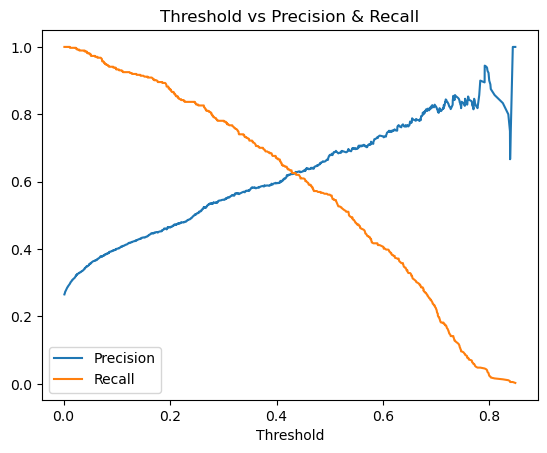

In [23]:
from sklearn.metrics import precision_recall_curve

y_scores = final_pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.title("Threshold vs Precision & Recall")
plt.legend()
plt.show()

In [26]:
desired_recall = 0.87
idx = np.where(recall >= desired_recall)[0][-1] 
best_threshold = thresholds[idx]

print(f"Hedeflenen Recall (%80) için gereken Eşik: {best_threshold:.2f}")

y_pred = (y_scores >= best_threshold).astype(int)

print(classification_report(y_test, y_pred))

Hedeflenen Recall (%80) için gereken Eşik: 0.20
              precision    recall  f1-score   support

           0       0.93      0.64      0.76      1035
           1       0.47      0.87      0.61       374

    accuracy                           0.70      1409
   macro avg       0.70      0.76      0.68      1409
weighted avg       0.81      0.70      0.72      1409



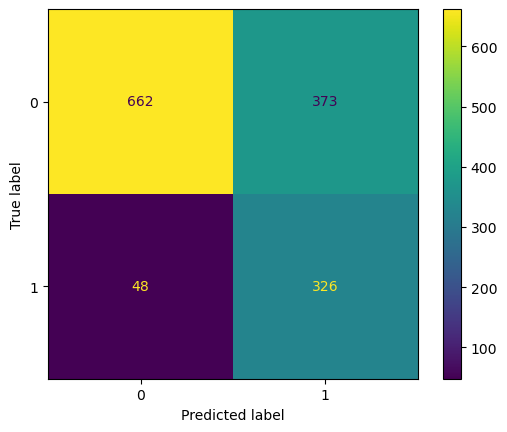

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred, labels=final_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=final_pipeline.classes_)
disp.plot()

plt.show()